In [1]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# read in our data
df_features=pd.read_csv('prices.csv')

df_features['date'] = pd.to_datetime(df_features['date'])
df_features.head()

,date,Ticker,open,close,low,high,volume
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000


In [3]:
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['date', 'Ticker', 'close']].copy()
        # generate dataframe to shift index by i day. 415 is number of stocks
        df_lag['date'] = df_lag['date'].shift(-i*415)
        df_lag.columns = ['date', 'Ticker', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['date', 'Ticker'], right_on = ['date', 'Ticker'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [4]:
df_features = create_lag_features(df_features, 3)
display(df_features)

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300,NaN,NaN,NaN,NaN
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700,NaN,NaN,NaN,NaN
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400,NaN,NaN,NaN,NaN
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900,NaN,NaN,NaN,NaN
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000,NaN,NaN,NaN,NaN
5,2010-01-04,ADBE,36.650002,37.090000,36.650002,37.299999,4710200,NaN,NaN,NaN,NaN
6,2010-01-04,ADI,31.790001,31.670000,31.610001,32.189999,2102700,NaN,NaN,NaN,NaN
7,2010-01-04,ADM,31.480000,31.469999,31.330000,31.840000,3472500,NaN,NaN,NaN,NaN
8,2010-01-04,ADS,65.000000,65.889999,64.959999,66.000000,794300,NaN,NaN,NaN,NaN
9,2010-01-04,ADSK,25.610001,25.670000,25.610001,25.830000,2228600,NaN,NaN,NaN,NaN


In [5]:
# finds all unique stocks
uniq_stocks = set(df_features['Ticker'])

In [6]:
# Technical Indicators
from technical_indicators import * # import all function

In [7]:
# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
X_one = df_features.loc[df_features['Ticker'] == 'MSFT', :]

In [8]:
display(X_one.head())

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3
260,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100,NaN,NaN,NaN,NaN
675,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600,0.032304,NaN,NaN,NaN
1090,2010-01-06,MSFT,30.879999,30.770000,30.520000,31.080000,58182400,-0.613692,0.032304,NaN,NaN
1505,2010-01-07,MSFT,30.629999,30.450001,30.190001,30.700001,50559700,-1.039971,-0.613692,0.032304,NaN
1920,2010-01-08,MSFT,30.280001,30.660000,30.240000,30.879999,51197400,0.689652,-1.039971,-0.613692,0.032304


In [9]:
a = ['Date', 'Ticker', 'Open', 'Close', 'Low', 'High', 'Volume', 'Today']
for i in range(1,4):
    a.append('lag' + str(i))
X_one.columns = a
X_one = X_one.reset_index(drop = True)

In [10]:
X_one = rate_of_change(X_one, 2)
X_one = standard_deviation(X_one, 14)

X_one = relative_strength_index(X_one, 14) # periods
X_one = average_directional_movement_index(X_one, 14, 13) # n, n_ADX
X_one = moving_average(X_one, 21) # periods
X_one = exponential_moving_average(X_one, 21) # periods
X_one = momentum(X_one, 14) # 

X_one = average_true_range(X_one, 14)
X_one = bollinger_bands(X_one, 21)
X_one = ppsr(X_one)
X_one = stochastic_oscillator_k(X_one)
X_one = stochastic_oscillator_d(X_one, 14)
X_one = trix(X_one, 14)
X_one = macd(X_one, 26, 12)
X_one = mass_index(X_one)
X_one = vortex_indicator(X_one, 14)

X_one = kst_oscillator(X_one, 10, 10, 10, 15, 10, 15, 20, 30)
X_one = true_strength_index(X_one, 25, 13)

X_one = accumulation_distribution(X_one, 14)
X_one = chaikin_oscillator(X_one)
X_one = money_flow_index(X_one, 14)
X_one = on_balance_volume(X_one, 14)
X_one = force_index(X_one, 14)
X_one = ease_of_movement(X_one, 14)
X_one = commodity_channel_index(X_one, 14)
X_one = keltner_channel(X_one, 14)
X_one = ultimate_oscillator(X_one)
X_one = donchian_channel(X_one, 14)

# # df.plot(y=['Close'])
# # df.plot(y=['RSI_14'])
# X_one.tail(5)

In [11]:
# drop earlier data with missing lag features
X_one.dropna(inplace=True)
X_one = X_one.reset_index(drop = True)

In [12]:
display(X_one)

,Date,Ticker,Open,Close,Low,High,Volume,Today,lag1,lag2,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
0,2010-03-08,MSFT,28.520000,28.629999,28.500000,28.930000,39414500,0.139906,-0.139710,0.597330,...,0.571429,-2.349979e+06,-3.505895e+06,2.112322e-10,0.374298,28.630476,29.084762,28.176190,3.650529,2.350000
1,2010-03-09,MSFT,28.559999,28.799999,28.549999,29.110001,50271600,0.593783,0.139906,-0.139710,...,0.571429,-2.036500e+06,9.216226e+05,1.627834e-10,1.088431,28.650952,29.124524,28.177381,3.569365,2.350000
2,2010-03-10,MSFT,28.860001,28.969999,28.799999,29.110001,44891400,0.590278,0.593783,0.139906,...,0.571429,-1.891150e+06,0.000000e+00,-5.230023e-12,1.771248,28.659762,29.118333,28.201190,3.265577,1.460001
3,2010-03-11,MSFT,28.889999,29.180000,28.850000,29.190001,35349700,0.724891,0.590278,0.593783,...,0.642857,3.808957e+06,-3.731861e+06,2.649101e-11,1.965740,28.679762,29.146191,28.213333,4.052324,1.460001
4,2010-03-12,MSFT,29.320000,29.270000,29.040001,29.379999,31700200,0.308430,0.724891,0.590278,...,0.714286,8.695193e+06,-2.703726e+06,1.776931e-10,2.086287,28.712381,29.182381,28.242381,4.189662,1.460001
5,2010-03-15,MSFT,29.180000,29.290001,29.010000,29.370001,37512000,0.068333,0.308430,0.724891,...,0.714286,1.510792e+07,-1.416405e+07,5.027716e-10,1.697311,28.770000,29.212857,28.327142,4.164341,1.460001
6,2010-03-16,MSFT,29.420000,29.370001,29.200001,29.490000,36723500,0.273131,0.068333,0.308430,...,0.714286,1.464775e+07,-4.767389e+06,5.053946e-10,1.744172,28.823810,29.258095,28.389524,4.118390,1.460001
7,2010-03-17,MSFT,29.500000,29.629999,29.400000,29.870001,50385700,0.885250,0.273131,0.068333,...,0.785714,2.172782e+07,1.699910e+06,9.294576e-10,2.068527,28.910238,29.333095,28.487381,4.199034,1.460001
8,2010-03-18,MSFT,29.629999,29.610001,29.500000,29.719999,43845200,-0.067492,0.885250,0.273131,...,0.714286,1.571241e+07,3.266127e+06,7.129558e-10,1.629855,28.976905,29.391191,28.562619,4.323757,1.469999
9,2010-03-19,MSFT,29.760000,29.590000,29.350000,29.900000,81332100,-0.067548,-0.067492,0.885250,...,0.714286,6.774014e+06,2.139022e+07,6.269322e-10,1.381905,29.030238,29.446667,28.613809,4.103175,1.719999


In [13]:
y_one = X_one['Today']
X_one.drop(['Open','Close','Low','High','Today','Ticker'], axis = 1, inplace = True)

In [14]:
X_train_one = X_one.loc[(X_one['Date'] < '2016-01-01'),:]
y_train_one = y_one[X_train_one.index]

X_test_one = X_one.loc[(X_one['Date'] < '2016-01-01'),:]
y_test_one = y_one[X_test_one.index]

In [15]:
# np.all(np.isfinite(X_train_one))
# # ACC/DIST ROC_14 is problem

In [16]:
X_train_one.drop(['Acc/Dist_ROC_14'], axis = 1, inplace = True)
X_test_one.drop(['Acc/Dist_ROC_14'], axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
X_train_one.drop(['Date'], axis = 1, inplace = True)
X_test_one.drop(['Date'], axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
# random forest regression
rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 10)
rf.fit(X_train_one.as_matrix().astype(np.float), y_train_one.as_matrix().astype(np.float))
print(mean_squared_error(y_test_one.as_matrix().astype(np.float), rf.predict(X_test_one.as_matrix().astype(np.float))))

0.006365593246090775


In [19]:
from sklearn.metrics import r2_score
r2_score(y_test_one.as_matrix().astype(np.float), rf.predict(X_test_one.as_matrix().astype(np.float)))

0.997055069560531

In [20]:
display(X_train_one.head())

,Volume,lag1,lag2,lag3,ROC_2,STD_14,RSI_14,ADX_14_13,MA_21,EMA_21,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
0,39414500,-0.139710,0.597330,0.000000,0.001399,0.185217,0.516356,0.184181,28.439047,28.634617,...,0.571429,-2.349979e+06,-3.505895e+06,2.112322e-10,0.374298,28.630476,29.084762,28.176190,3.650529,2.350000
1,50271600,0.139906,-0.139710,0.597330,0.005938,0.188582,0.582992,0.181562,28.476190,28.649861,...,0.571429,-2.036500e+06,9.216226e+05,1.627834e-10,1.088431,28.650952,29.124524,28.177381,3.569365,2.350000
2,44891400,0.593783,0.139906,-0.139710,0.005903,0.188582,0.582992,0.188360,28.535714,28.679332,...,0.571429,-1.891150e+06,0.000000e+00,-5.230023e-12,1.771248,28.659762,29.118333,28.201190,3.265577,1.460001
3,35349700,0.590278,0.593783,0.139906,0.007249,0.232988,0.614426,0.213136,28.591428,28.725369,...,0.642857,3.808957e+06,-3.731861e+06,2.649101e-11,1.965740,28.679762,29.146191,28.213333,4.052324,1.460001
4,31700200,0.724891,0.590278,0.593783,0.003084,0.279639,0.680438,0.228431,28.652381,28.775397,...,0.714286,8.695193e+06,-2.703726e+06,1.776931e-10,2.086287,28.712381,29.182381,28.242381,4.189662,1.460001


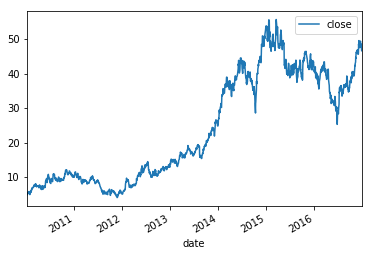

In [21]:
import matplotlib.pyplot as plt

a = df_features.loc[df_features.loc[:,'Ticker'] == 'AAL', ['date', 'close']]
a.plot(x = 'date', y = 'close')
plt.show()